# Figure 5

In [2]:
## Basics
import numpy as np
import pandas as pd
import re
import random
import glob
from scipy import stats

## Bio functions
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq

## Local functions
import sys
sys.path.append("../code/scripts")
import composition as comp

## Plotting
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

## Set seed for consistency
### In the future when writing code with random remember to use new methods which explicitly create generators
seed = 212121


In [3]:
def cov(group, absolute=True):
    """
    Calculates the coefficient of variation for an iterable of values group.
    By default use the absolute value of the mean (absolute=True); set to False to use the signed value.
    """
    
    std = np.sqrt(np.nanvar(group))
    if not absolute:
        return(std / np.nanmean(group))
    else:
        return(std / np.abs(np.nanmean(group)))

In [4]:
all_cr_data = pd.read_csv("../data/charged_regions/cr_filtered_aflabel.csv", comment = "#")
eIF3As = all_cr_data[all_cr_data['gene']=="RPG1"]
eIF3As

,orf,gene,seq.len,left.bound,right.bound,region.seq,region.len,charge.asymmetry,frac.charge,kappa1,kappa2,uni_id,orf_label,label
28,YBR079C,RPG1,965,499,549,ASTASKEVSEEENTEPEVQEEKEETDEALGPQETEDGEEKEEESDP...,51,0.226667,0.490196,0.064919,0.231738,P38249,verified,disordered
29,YBR079C,RPG1,965,571,618,NASYMEKVRIARETLIKKNKDDLEKISKIVDERVKRSQEQKQKHMEHA,48,0.015152,0.458333,0.041641,0.105198,P38249,verified,helix
30,YBR079C,RPG1,965,790,852,HVSGTKESELAAIRNQKKAELEAAKKARIEEVRKRRYEEAIARRKE...,63,0.008466,0.476190,0.079436,0.182138,P38249,verified,helix


## Sequence entropy

In [5]:
eIF3A_af = AlignIO.read('../data/eIF3A/eIF3A-af-aligned.fa', format='fasta')
eIF3A_af_mat = np.asarray(eIF3A_af)

# Alignment Boundaries of N-terminal region of interest in S. cerevisiae
start = 922
end = 1032

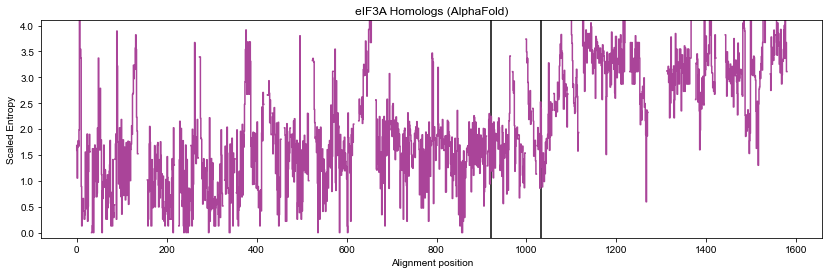

In [6]:
eIF3A_af_seq_ents = []
coverage_cutoff = 0.1

for p, pos in enumerate(eIF3A_af_mat.T):
    eIF3A_af_seq_ents.append(stats.entropy(comp.get_character_freqs(pos, gaps=True)[0]))

coverage_weights = []
    
for p, pos in enumerate(eIF3A_af_mat.T):
    seqlen = len(''.join(pos))
    coverage = seqlen / (seqlen - ''.join(pos).count('-'))
    if 1/coverage < coverage_cutoff:
        coverage_weights.append(np.nan)
    else:
        coverage_weights.append(coverage)
    
plt.figure(figsize=(14, 4))
plt.step(np.arange(0, len(eIF3A_af_seq_ents)),
         np.array(eIF3A_af_seq_ents)*np.array(coverage_weights), color = cscheme['cr'])
plt.vlines(x = start, ymin=-5, ymax=100, color="black")
plt.vlines(x = end, ymin=-5, ymax=100, color="black")
plt.xlabel('Alignment position')
plt.ylabel('Scaled Entropy')
plt.title("eIF3A Homologs (AlphaFold)")
plt.ylim(-0.1, 4.1)
#plt.savefig("plots/")
plt.show()

In [7]:
# for each alignment dataset
# identify region
# iterate through rows, remove gaps, and return length

def get_region_lengths(msa, start, end):
    """
    Given an AlignIO object (msa), return a vector of the lengths of all the regions in a range from start to end 
    (inclusive) without gaps
    """
    lengths = []
    for spec in msa:
        region_seq = str(spec.seq[start:end+1]).replace("-", "")
        lengths.append(len(region_seq))
    return(lengths)

af_lengths = get_region_lengths(eIF3A_af, start, end)

In [8]:
print(af_lengths)
print(np.sqrt(np.var(af_lengths)))

[83, 88, 63, 63, 81, 81, 99, 70, 70, 70, 70, 82, 92, 99, 92, 92, 92, 92, 92, 92, 87, 93, 81, 81, 81, 90, 90, 90, 90, 91, 92, 92, 92, 92, 92]
9.472021097604744


## Secondary Structure Prediction from Alphafold

In [9]:
import mdtraj as md
def find_species_name(filepath):
    """
    Parse a line of a pdb file and look for a species name in the header
    """
    search_string = re.compile("ORGANISM_SCIENTIFIC: (.*)")
    with open(filepath) as file:
        resids = []
        pLDDTs = []
        for line in file:
            if line[0:8] == "SOURCE  ":
                m = re.search(search_string, line)
                if m:
                    cleaned = re.sub(r'[^A-Za-z0-9 ]+', '', m.group(1)).strip()
                    # replace whitespace with underscore; muscle breaks at whitespace leading to duplicate entries
                    cleaned = re.sub(" ", "_", cleaned)
                    return(cleaned)


In [10]:
eIF3A_af_ss = {}

for struct in glob.glob('../data/eIF3A/*.pdb'):
    species_name = find_species_name(struct)
    s = md.load(struct)
    ss = md.compute_dssp(s, simplified=True)[0]
    eIF3A_af_ss[species_name] = ss

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


## Secondary Structure on Alignment

In [11]:
recs = []

for sp in eIF3A_af:
    sequence = []
    i = 0
    for a, aa in enumerate(sp.seq):
        if aa == '-':
            sequence.append('-')
        else:
            if eIF3A_af_ss[sp.id][i] not in ["H", "E", "C"]:
                print(sp.id)
                print(a)
                break
            sequence.append(eIF3A_af_ss[sp.id][i])
            i += 1
    sequence = ''.join(sequence)        
    record = SeqIO.SeqRecord(seq = Seq(sequence), id = sp.id)
    recs.append(record)
    
eIF3A_ss_alignment = AlignIO.MultipleSeqAlignment(records=recs)

In [12]:
print(eIF3A_ss_alignment[:, start:end])

Alignment with 35 rows and 110 columns
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...CCC DICTYOSTELIUM_DISCOIDEUM
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH MONOSIGA_BREVICOLLIS
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-----...HHH VANDERWALTOZYMA_POLYSPORA_STRAIN_ATCC_22028
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--------...HHH SACCHAROMYCES_CEREVISIAE_STRAIN_ATCC_204508
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH KLUYVEROMYCES_LACTIS_STRAIN_ATCC_8585__CBS
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH ASHBYA_GOSSYPII_STRAIN_ATCC_10895__CBS_10951
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH-...HHH CRYPTOCOCCUS_NEOFORMANS_VAR_NEOFORMANS_SEROTYPE
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH CANDIDA_ALBICANS_STRAIN_SC5314__ATCC
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH LODDEROMYCES_ELONGISPORUS_STRAIN_ATCC_11503
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...CCC MEYEROZYMA_GUILLIERMONDII_STRAIN_ATCC_6260
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH--...HHH DEBARY

In [44]:
#SeqIO.write(eIF3A_ss_alignment, "../data/eIF3A/eIF3A-ss-aligned.fa", "fasta")

35

## Length Variation

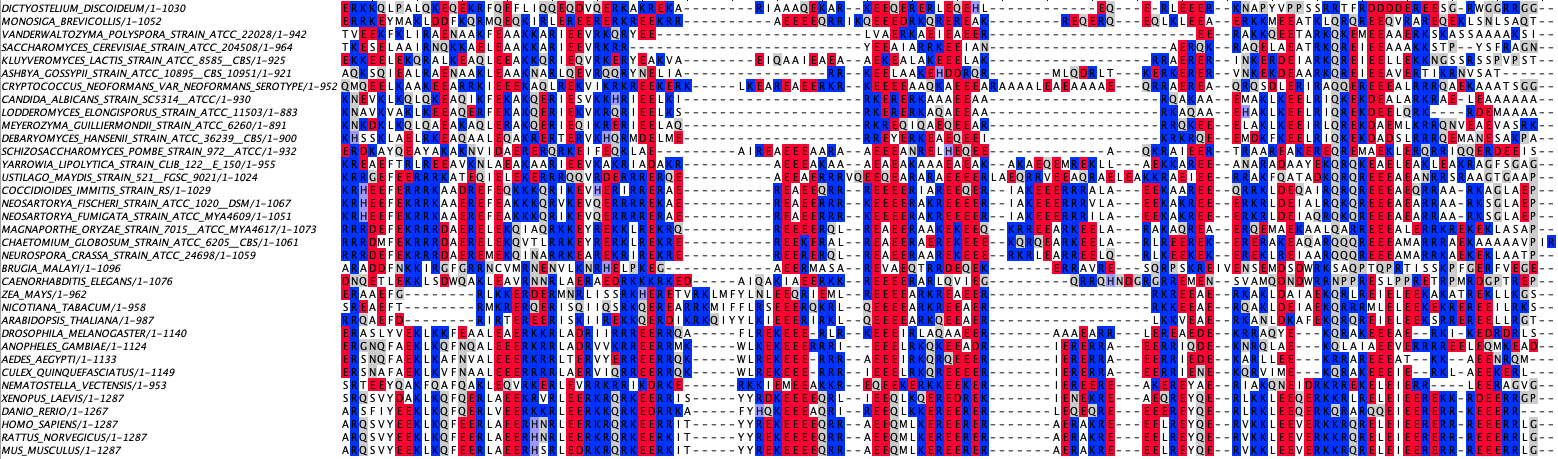

In [13]:
Image("../data/eIF3A/eIF3A-seq.png")

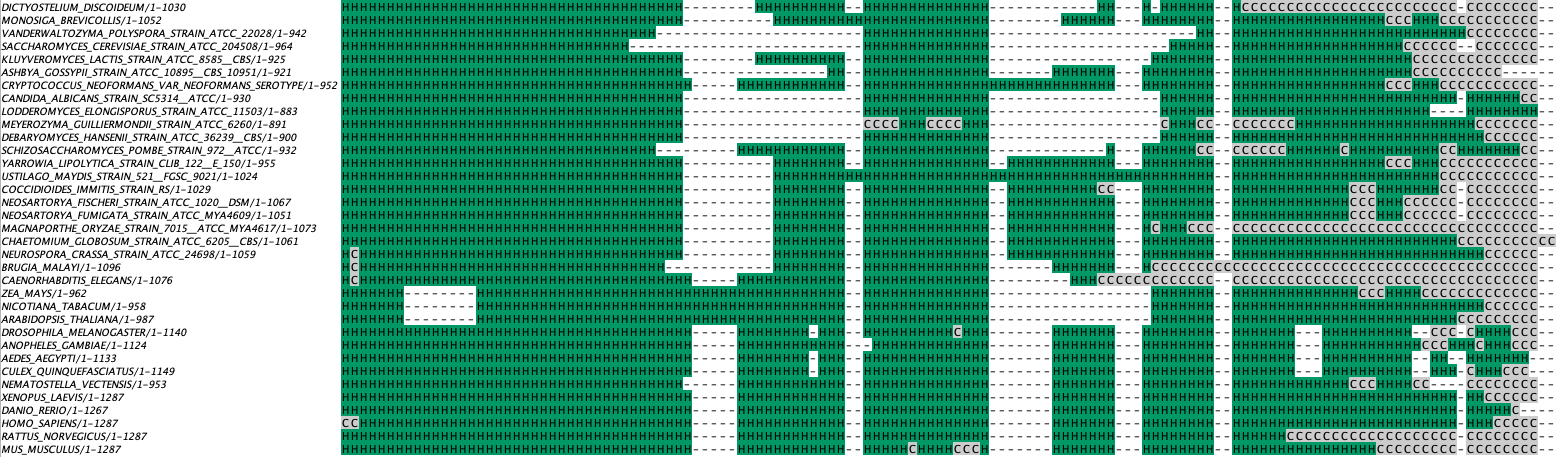

In [15]:
Image("../data/eIF3A/eIF3A-ss.png")

In [16]:
break_at = 'CCCC'

charge_helix_lengths = []
for sp in eIF3A_ss_alignment:
    seq = str(sp.seq[start:])
    seq = seq.replace("-", "")
    h = re.search(break_at, seq)
    hbreak = h.start()
    charge_helix_lengths.append(hbreak)
    
#print(charge_helix_lengths)

In [17]:
N_helix_lengths = []
for sp in eIF3A_ss_alignment:
    seq = str(sp.seq[95:])
    seq = seq.replace("-", "")
    h = re.search(break_at, seq)
    hbreak = h.start()
    N_helix_lengths.append(hbreak)
    
#print(N_helix_lengths)

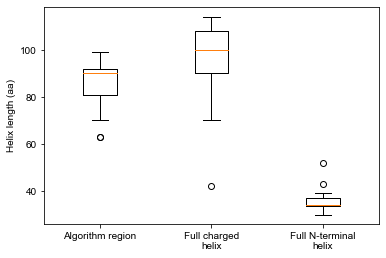

In [18]:
fig, ax = plt.subplots(figsize = (6,4))
bp = ax.boxplot([af_lengths, charge_helix_lengths, N_helix_lengths])
ax.set_xticklabels(['Algorithm region', "Full charged\nhelix", "Full N-terminal\nhelix"])
ax.set_ylabel("Helix length (aa)")
plt.show()

In [19]:
print("Algorithm length COV: {}".format(cov(af_lengths)))
print("Helix length COV: {}".format(cov(charge_helix_lengths)))
print("N terminal helix length COV: {}".format(cov(N_helix_lengths)))

Algorithm length COV: 0.1106175303357244
Helix length COV: 0.1681206663488094
N terminal helix length COV: 0.11158270012030046


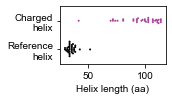

In [23]:
to_plot = pd.DataFrame(np.array([charge_helix_lengths, N_helix_lengths]).T, columns=["cr", "null"])
to_plot = pd.melt(to_plot, value_name='Length', var_name='Region')
fig = plt.figure(figsize=(2.5,1.5))
ax = sns.swarmplot(x = 'Length', y = 'Region', data=to_plot, orient='h', palette=cscheme, size=2)
ax.set_yticklabels(["Charged\nhelix", "Reference\nhelix"])
ax.set_ylabel(None)
plt.xlabel("Helix length (aa)")
plt.tight_layout()
plt.savefig("plots/Figure5C.pdf")
plt.show()